In [1]:
pip install yfinance

  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)
Using cached frozendict-2.4.6-py311-none-any.whl (16 kB)

   ---------------------------------------- 0/5 [peewee]
   ---------------------------------------- 0/5 [peewee]
   ------------------------ --------------- 3/5 [curl_cffi]
   ------------------------ --------------- 3/5 [curl_cffi]
   -------------------------------- ------- 4/5 [yfinance]
   -------------------------------- ------- 4/5 [yfinance]
   -------------------------------- ------- 4/5 [yfinance]
   ---------------------------------------- 5/5 [yfinance]

Note: you may need to restart the kernel to use updated packages.


#### **API 키 설정**

In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

#### **웹 검색과 코드 실행 도구 정의**

In [2]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

C:\Users\SBA\AppData\Local\Temp\ipykernel_20624\114800678.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


#### **yfinance로 주어진 주식 종목에 대한 최근 주가 및 재무 분석 도구 정의**

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2025-09-15': 177.75,
 '2025-09-16': 174.8800048828125,
 '2025-09-17': 170.2899932861328,
 '2025-09-18': 176.24000549316406,
 '2025-09-19': 176.6699981689453}

In [4]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.
    
    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

#### **Supervisor 에이전트 정의**

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

#### **하위 에이전트 정의 함수**

In [8]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

#### **하위 에이전트 설정**

In [10]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
#research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_agent = create_react_agent(llm, tools=[tavily_tool], prompt=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], prompt=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], prompt=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [11]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

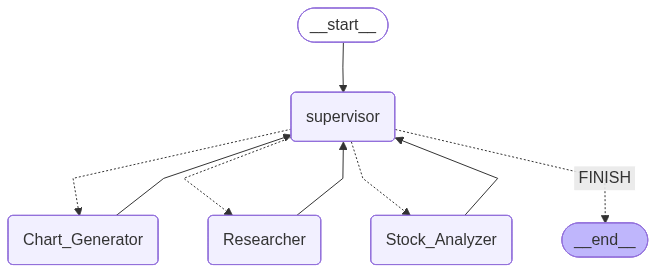

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='애플(Apple, AAPL) 주식 구매 결정을 위한 몇 가지 중요한 정보는 다음과 같습니다:\n\n1. **주가 동향**:\n   - 2023년 10월 31일에 애플의 주가는 169.11달러로 마감했습니다. 같은 달 다른 주요 날짜에서의 주가는 다음과 같았습니다:\n     - 10월 30일: 168.64달러\n     - 10월 27일: 166.59달러\n     - 10월 25일: 169.44달러\n   - 최근 몇 주간의 가격은 다소 변동성이 있었으나, 현재 주가는 160달러 중반에 가까운 수준에서 거래되고 있습니다. \n   - [StatMuse Money](https://www.statmuse.com/money/ask/apple-stock-price-oct-2023)에서 더 많은 주가 정보를 확인할 수 있습니다.\n\n2. **재무 성과**:\n   - 애플은 2023 회계연도에 2980억 달러의 제품 판매와 850억 달러의 서비스 판매를 기록했습니다. 분석에 따르면 제품 판매는 전년 대비 6% 감소했지만 서비스 판매는 9% 증가했습니다. \n   - 총매출은 전년 대비 3% 감소하였으나, 총 이익률은 44%로 높은 편입니다.\n   - [Forrester의 애플 판매 및 이익 분석](https://www.forrester.com/blogs/apple-sales-and-profits-analysis-for-fy-2023-top-10-insights/)에서 더욱 상세한 정보를 확인할 수 있습니다.\n\n3. **위험 요소**:\n   - 시장 내 경쟁이 치열하며, 가격 압박이 지속되고 있습니다. 또한, 소비자와 기업의 가격 민감도가 높아져서 이익률이 변동할 수 있는 리스크가 있습니다.\n   - 경기가 악화되면 거래 채무의 신용 위험이 증가하고 재무 상태에 부정적인 영향을 미칠 수 있습

Python REPL can execute arbitrary code. Use with caution.


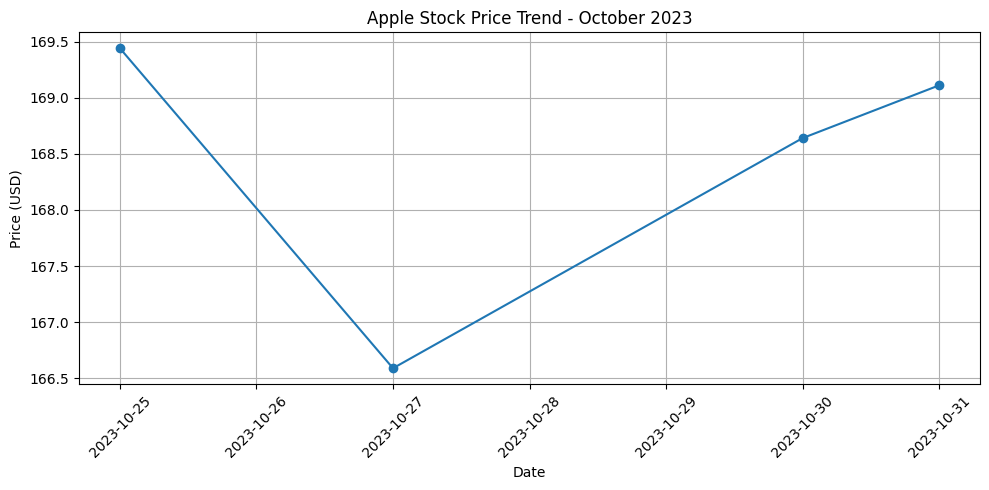

{'Chart_Generator': {'messages': [HumanMessage(content="Here is the stock price trend for Apple (AAPL) for October 2023:\n\n![Apple Stock Price Trend - October 2023](attachment://plot.png) \n\nThe chart shows the fluctuations in Apple's stock price from October 25 to October 31, 2023. You can observe the slight variations in the prices during this week.", additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [13]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")